# Introduction

In this notebook, we'll use a deep learning model to segment brain tumors from multi-parametric MRI and then extract features from the resulting tumor masks. Such features can potentially be associated with tumor severity and prognosis and contribute to better treatment. 

We'll use data from the TCGA collection discussed by Arvid earlier today (see the slides at https://github.com/MMIV-ML/nordoc2022):

![](https://progenetix.org/img/tcga.png)

![](assets/tcga.png)

# Setup

As always, we need to import some libraries and decide where to fetch and store data.

In [1]:
%matplotlib inline

In [2]:
import os, sys, pandas as pd, numpy as np, random, seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import nibabel as nib

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
NB_DIR = Path.cwd()
LOCAL_DATA = NB_DIR/'..'/'data'
IMG_DATA = LOCAL_DATA/'TCGA'

# Brain tumor imaging data

We will use a small sample data set from the TCGA collection. For simplicity, we use versions of the MRI images that have already been co-registered and converted to NIfTI format: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=24282668. This saves us a few steps.

We've prepared a small sample data set containing data from 10 subjects:

In [5]:
sample_df = pd.read_csv(LOCAL_DATA/'TCGA-sample_data.csv')

In [6]:
sample_df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413
5,TCGA-06-6389,49.0,female,glioblastoma,G4,Mutant,IDH1,non-codel,7.7866,100.0,TCGA-06-6389
6,TCGA-14-1456,23.0,male,glioblastoma,G4,Mutant,IDH1,non-codel,40.9372,80.0,TCGA-14-1456
7,TCGA-14-3477,38.0,female,glioblastoma,G4,WT,NaN,non-codel,3.7783,80.0,TCGA-14-3477
8,TCGA-19-5954,72.0,female,glioblastoma,G4,WT,NaN,non-codel,7.9509,60.0,TCGA-19-5954
9,TCGA-76-6656,66.0,male,glioblastoma,G4,WT,NaN,non-codel,4.8297,60.0,TCGA-76-6656


For convenience, the corresponding images have already been downloaded:

In [7]:
sorted(list((IMG_DATA/sample_df['img_dir'].values[0]).iterdir()))

[PosixPath('/home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_flair.nii.gz'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t1.nii.gz'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t1Gd.nii.gz'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/TCGA-06-0145_2000.11.06_t2.nii.gz'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/seg')]

Here are all the subject IDs in our sample data set:

In [8]:
subject_ids = sample_df['img_dir'].values
subject_ids

array(['TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', 'TCGA-06-5408',
       'TCGA-06-5413', 'TCGA-06-6389', 'TCGA-14-1456', 'TCGA-14-3477',
       'TCGA-19-5954', 'TCGA-76-6656'], dtype=object)

## Plot some images

It's very important to inspect your data. After fetching the data and after performing any transformations on the data. In the case of images, that typically means displaying the images:

In [9]:
def plot_image(subj_id, slice_nb):
    images = [nib.load(i) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    nb_slices = images[0].shape[-1]
    
    flair, t1, t1c, t2 = [np.flip(np.rot90(i.get_fdata()[:,:,slice_nb])) for i in images]

    f,axs = plt.subplots(1,4, figsize=(18,5))
    axs[0].imshow(flair, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(t1, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(t1c, cmap="gray")
    axs[2].axis("off")
    axs[3].imshow(t2, cmap="gray")
    axs[3].axis("off")

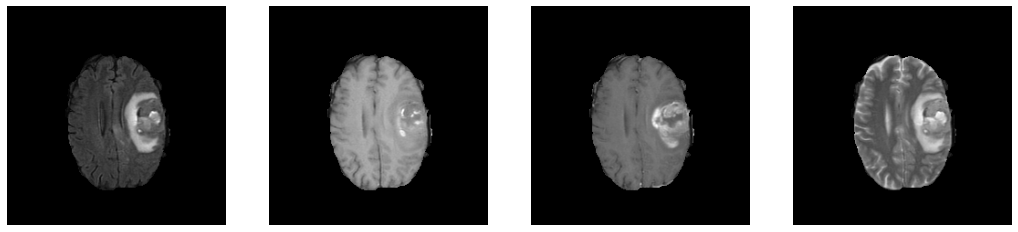

In [10]:
plot_image(subject_ids[0], slice_nb=100)

Understanding the data is such a crucial part of any machine learning project that it's worthwhile to spend a lot of time figuring out ways to construct functions to plot and to inspect features of the data. By using IPyWidgets, we can make our plots interactive:

In [11]:
from ipywidgets import interactive, IntSlider, Select

In [12]:
select_layer = IntSlider(value=100, min=0, max=154, 
                         description='Slice', continuous_update=False)

select_subj = Select(options=subject_ids, description="Subject")

In [13]:
interactive(plot_image, subj_id=select_subj, slice_nb=select_layer)

interactive(children=(Select(description='Subject', options=('TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', '…

We should also attempt to understand the _distribution_ of the downloaded data in various ways. We can for example ask what  the variation in mean voxel intensities is for each of the image sequences.

In [14]:
intensities = {}
for subj_id in subject_ids:
    flair, t1, t1c, t2 = [np.mean(nib.load(i).get_fdata()) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    intensities[subj_id] = [flair, t1, t1c, t2]

In [15]:
df_intensities = pd.DataFrame.from_dict(intensities, orient='index', 
                                       columns = ['flair', 't1', 't1c', 't2'])

In [16]:
df_intensities

,flair,t1,t1c,t2
TCGA-06-0145,15.592199,34.489715,37.917576,44.270152
TCGA-06-0190,25.485854,46.296293,50.513481,57.134856
TCGA-06-0646,39.505776,77.770795,89.003278,91.876778
TCGA-06-5408,28.564800,49.455247,53.418037,62.991788
TCGA-06-5413,51.155407,78.149601,107.871139,119.434830
TCGA-06-6389,49.575452,71.530700,89.746512,137.181183
TCGA-14-1456,24.673250,42.779937,46.009659,82.604169
TCGA-14-3477,53.518731,48.101099,54.656742,72.503977
TCGA-19-5954,47.905887,40.451770,45.331130,95.440951
TCGA-76-6656,97.105232,77.719332,86.992573,127.178461


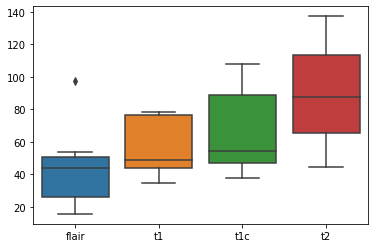

In [17]:
sns.boxplot(data=df_intensities)
plt.show()

We observe quite some variation in the mean voxel intensities across the data set. This leads to a need for some kind of normalization.

# Brain tumor segmentation using HD-GLIO

In this case, we will use an existing model that has already been trained on a large collection of MRI examinations (3220 examinations from 1450 brain tumor patients, sourced from multiple centers). The pipeline, including the trained model and various preprocessing steps, is freely available via the code-sharing platform **GitHub** under an **open source license** (Apache-2.0): https://github.com/NeuroAI-HD/HD-GLIO. 

![](assets/open-source.png)

HD-GLIO was constructed as a collaboration between the Department of Neuroradiology at the Heidelberg University Hospital, Germany and the Division of Medical Image Computing at the German Cancer Research Center (DKFZ) Heidelberg, Germany.

## The network architecture: U-Net and the nnU-Net

HD-GLIO is based on a version of the widely used U-Net architecture (also used in our previous notebook). Specifically, it is based on a variant of the open source nnU-Net ("no-new-Net"), available here: https://github.com/MIC-DKFZ/nnUNet. 

The main point of nnUNet is that there is a lot of performance gains to be had by optimizing the deep learning workflow--preprocessing, postprocessing, etc, rather than creating completely new artificial neural network architectures. You can read all about the ideas here: https://www.nature.com/articles/s41592-020-01008-z.

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41592-020-01008-z/MediaObjects/41592_2020_1008_Fig2_HTML.png)

## Running HD-GLIO on our data

We create a small helper function to run HD-GLIO

In [18]:
def run_hdglio(t1, t1c, t2, flair, output):
    
    !CUDA_VISIBLE_DEVICES=1 $sys.exec_prefix/bin/hd_glio_predict -t1 $t1 -t1c $t1c -t2 $t2 -flair $flair -o $output
    
    return output

...and run the already trained model on all our subjects:

In [19]:
i=1
for subj in subject_ids:
    
    # Specify the file name for the output segmentation
    output_file = LOCAL_DATA/"TCGA"/subj/"seg"/f"{subj.split('/')[-1]}_seg.nii.gz"
    
    # Grab the file names for the four images (T1, T1c, T2, FLAIR)
    flair, t1, t1c, t2 = sorted(list((IMG_DATA/subj).glob("*.nii*")))
    
    # Run HDGLIO (note that it is possible to run HD-GLIO in batch mode, avoiding 
    # having to load the model every time. See the HD-GLIO docs for more)
    print(f"Processing subject #{i}/{len(subject_ids)}: {subj.split('/')[-1]}")
    !$sys.exec_prefix/bin/hd_glio_predict -t1 $t1 -t1c $t1c -t2 $t2 -flair $flair -o $output_file  > /dev/null
    
    print("-"*40)
    print(f"DONE. Output available at {output_file}")
    print()
    
    i+=1

Processing subject #1/10: TCGA-06-0145
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0145/seg/TCGA-06-0145_seg.nii.gz

Processing subject #2/10: TCGA-06-0190
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0190/seg/TCGA-06-0190_seg.nii.gz

Processing subject #3/10: TCGA-06-0646
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-0646/seg/TCGA-06-0646_seg.nii.gz

Processing subject #4/10: TCGA-06-5408
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TCGA/TCGA-06-5408/seg/TCGA-06-5408_seg.nii.gz

Processing subject #5/10: TCGA-06-5413
----------------------------------------
DONE. Output available at /home/ubuntu/Dropbox/medGPU-alex/NORDOC2022/nbs/../data/TC

## Inspect results

We've now produced segmentation masks for our tumor images. Here's a a small widget to plot the resulting segmentation masks and the corresponding T2 images.

In [20]:
from ipywidgets import ToggleButtons, fixed

In [21]:
classes_dict = {
    'Normal': 0.,
    'Contrast-enhancing': 1.,
    'Non-enhancing': 2.,
}

In [22]:
# Plotting function
def plot_segmentation(subj_id, seg_class, slice_nb):
    
    flair, t1, t1c, t2 = [nib.load(i) for i in sorted(list((IMG_DATA/subj_id).glob("*.nii*")))]
    mask = nib.load(list((IMG_DATA/subj_id/"seg").glob("*.nii*"))[0])
    
    nb_slices = t2.shape[-1]
    
    img_data = np.flip(np.rot90(t2.get_fdata()[:,:,slice_nb]))
    mask_data = np.flip(np.rot90(mask.get_fdata()[:,:,slice_nb]))
    
    print(f"Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(mask_data == img_label, 255, 0)
    
    f,axs = plt.subplots(1,3, figsize=(18,5))
    axs[0].imshow(img_data, cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='binary')
    axs[1].axis('off')
    axs[2].imshow(mask, cmap="Blues")
    axs[2].imshow(img_data, cmap="gray", alpha=0.7)
    axs[2].axis("off")

Set up the interactive elements of our widget:

In [23]:
# Button
select_class = ToggleButtons(
    options=['Contrast-enhancing', 'Non-enhancing'],
    description='Select Label:',
    button_style='info', 
    
)
# Slice slider
select_layer = IntSlider(value=100, min=0, max=254, 
                         description='Slice', continuous_update=False)

# Subject selector
select_subj = Select(options=subject_ids, description="Subject")

In [24]:
interactive(plot_segmentation, subj_id=select_subj,
            seg_class=select_class, slice_nb=select_layer)

interactive(children=(Select(description='Subject', options=('TCGA-06-0145', 'TCGA-06-0190', 'TCGA-06-0646', '…

# Radiomics: extracting tumor features

Now we have an estimate of the locations and extent of the T2-enhancing and -non-enhancing regions of the tumors. We can use this to extract the tumor location and the tumor burden. Additionally, we can have a look at the features of the MRI images inside each of these two tumor parts. And do what's called **radiomics**.

![](assets/radiomics.png)

We use an established, open source library developed by the imaging community, PyRadiomics. The library aims to be the reference standard for radiomic analysis, easing both analyses and enabling greater reproducibility. It's available on GitHub: https://github.com/AIM-Harvard/pyradiomics.

There is a vast number of possible features to extract (at least several hundreds, depending on the number of imaging modalities), related to shape, intensity values and variation, and texture features from each of the MRI modalities. The robustness and relevance of the various features is somewhat unclear, but there's a lot of research into the clinical relevance of radiomics.

For demonstration purposes, we extract only the total volumes, a few shape features, and some texture information. More precisely, we extract:

1. The size of the enhancing and non-enhancing tumor
2. The maximum 3D diameter
3. Mean and variance of the intensities in the T1, T1c, T2, FLAIR in the enhancing and non-enhancing areas
4. The gray level nonuniformity in T1, T1c, T2, FLAIR.

We specify the features we'd like to extract in a file (YAML format):

In [25]:
#%cat pyradiomics_settings.yaml

In [26]:
from radiomics import featureextractor

In [27]:
def get_radiomics(images, mask, params='pyradiomics_settings.yaml'):
    results = {}
    
    subject_id = images[0].stem.split("_")[0]
    results['SUBJECT ID'] = subject_id
    
    # Some features are the same across all individual MRI image sequences 
    # We can extract them from any sequence

    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.loadParams(params)
    
    
    result_label1 = extractor.execute(str(images[0]), mask, label=1)
    result_label2 = extractor.execute(str(images[0]), mask, label=2)
        
    results[f'Volume_label1'] = result_label1['original_shape_MeshVolume']
    results[f'Volume_label2'] = result_label2['original_shape_MeshVolume']
        
    results[f'Max3DDiameter_label1'] = result_label1['original_shape_Maximum3DDiameter']
    results[f'Max3DDiameter_label2'] = result_label2['original_shape_Maximum3DDiameter']
    
    
    
    # Other features we extract from each individual type of MRI image

    for img in images:
        img_type = img.stem.split("_")[-1].split(".")[0]
        result_label1 = extractor.execute(str(img), mask, label=1)
        result_label2 = extractor.execute(str(img), mask, label=2)
        
        
        # Mean intensity
        
        results[f'{img_type}_MeanIntensity_label1'] = result_label1['original_firstorder_Mean']
        results[f'{img_type}_MeanIntensity_label2'] = result_label2['original_firstorder_Mean']
        
        # Intensity variance
        
        results[f'{img_type}_IntensityVariance_label1'] = result_label1['original_firstorder_Variance']
        results[f'{img_type}_IntensityVariance_label2'] = result_label2['original_firstorder_Variance']
        
        # Gray level nonuniformity
        
        results[f'{img_type}_GrayLevelNonUniformity_label1'] = result_label1['original_gldm_GrayLevelNonUniformity']
        results[f'{img_type}_GrayLevelNonUniformity_label2'] = result_label2['original_gldm_GrayLevelNonUniformity']       
        
        
    results = pd.DataFrame.from_dict(results, orient='index').T
    
    return results

## Run on all subjects

In [28]:
results = []

for subject_id in subject_ids:
    print(f"Computing radiomic features for subject {subject_id}")
    images = sorted(list((LOCAL_DATA/'TCGA'/subject_id).glob('*.nii.gz')))
    mask = str(list((LOCAL_DATA/'TCGA'/subject_id/'seg').glob('*.nii.gz'))[0])
    res = get_radiomics(images, mask)
    results.append(res)

Computing radiomic features for subject TCGA-06-0145
Computing radiomic features for subject TCGA-06-0190
Computing radiomic features for subject TCGA-06-0646
Computing radiomic features for subject TCGA-06-5408
Computing radiomic features for subject TCGA-06-5413
Computing radiomic features for subject TCGA-06-6389
Computing radiomic features for subject TCGA-14-1456
Computing radiomic features for subject TCGA-14-3477
Computing radiomic features for subject TCGA-19-5954
Computing radiomic features for subject TCGA-76-6656


We construct a data frame that stores the resulting radiomic features:

In [29]:
radiomic_df = pd.concat(results)

In [30]:
radiomic_df

,SUBJECT ID,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2
0,TCGA-06-0145,30701.666666666668,26001.333333333332,72.69112738154499,56.60388679233962,545.8921598093483,520.2659944716356,17906.52913629047,38098.035974081926,44.54177215189873,35.222493142334656,272.2881671222263,300.8911941405508,760.963814509348,2055.9279469481894,218.96708860759495,124.33434928375495,263.96195090861215,403.4730680715558,1252.2859371457898,6356.05685158767,195.89822784810127,68.0149344711978,369.1607148119912,374.6749633934668,4666.609879669028,8987.498390312292,81.16911392405063,61.59006400487656
0,TCGA-06-0190,128178.66666666667,25481.333333333332,103.42146779078317,54.99090833947008,448.47799891863787,414.05654600791354,8183.998034473703,5077.549554372548,306.95888290296614,64.88644918444166,219.34303009950298,231.09337814898936,525.2833718668651,313.05529043499405,987.6021425475261,264.5583437892095,202.11789737420634,446.1568283538355,942.4245096865451,11401.596254106298,809.469874295622,41.909033877038894,315.6983059743882,345.50360072575234,3926.5152210325878,3926.4799072176406,370.7832683138275,79.02948557089084
0,TCGA-06-0646,15071.0,4880.333333333333,65.05382386916237,44.090815370097204,368.23676553751045,315.7693354455521,1062.9440616966094,2117.9095889277314,92.98032107716209,32.98073836276083,217.28098030878843,163.59997994271262,2668.4715551862255,761.8727425979386,53.53754531330917,41.080256821829856,200.47460352098344,563.0710983494077,4860.439596547637,20406.86922785635,44.81874676333506,8.081861958266453,290.6262460329831,306.0439045489912,2745.869626848196,1011.1389320704045,53.23925427239772,42.81701444622793
0,TCGA-06-5408,121208.0,50953.0,99.31767214348109,83.09031231136396,429.72426684052107,377.2527808311832,7213.604300696047,7954.841262169011,252.65366492146597,101.60539523212046,241.71891632283172,256.99656876927025,732.9332289639475,690.7978677095699,833.9933246073299,375.7681932245922,228.82676088461366,404.0059628094657,1056.9074064245015,6694.625162770309,702.0369109947644,109.29015056461732,322.2113838593451,347.74623680549706,3648.171999648121,3265.09845728651,367.36832460732984,158.96957340025094
0,TCGA-06-5413,33458.666666666664,20032.666666666668,77.43384273042376,48.579831205964474,328.58563623859953,257.4923757296716,844.7533902348517,1505.888916048035,215.12354312354313,101.25448743518149,190.80601735480616,177.51050037401896,1941.8290595868957,1684.2995029226668,138.202331002331,90.71280414838452,171.68015038779063,351.8616641986365,2121.751960558949,11083.817264329013,134.2983682983683,37.81212604706821,263.80954202928586,241.5918065739007,1824.6695527099093,1936.2697336204399,138.97342657342656,89.79776625448744
0,TCGA-06-6389,25354.333333333332,22306.0,69.07966415668217,76.57675887630658,346.2757529769721,292.97837947277236,1138.5853330208147,1413.0543090041788,138.17476923076924,127.63742483197736,200.65175708504074,144.92784425083443,1874.828023009636,1857.5384807389592,106.83753846153846,103.78811460912628,198.5955143738219,367.5197062241018,2450.4490182776485,8321.198014179177,100.32492307692307,43.23770781747435,245.79236291633177,255.77979169534046,1399.2287516374479,1615.5748363951716,124.78030769230769,111.47683056243368
0,TCGA-14-1456,71234.0,9018.666666666666,77.56287771866127

In [31]:
radiomic_df['tumor_volume'] = radiomic_df['Volume_label1'] + radiomic_df['Volume_label2']

## Construct our final data set

Now we can append these features to the other information we have about each subject in the data set: 

In [32]:
sample_df.head()

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413


In [33]:
df = pd.merge(sample_df, radiomic_df, on="SUBJECT ID")

We're left with quite an interesting data set:

In [34]:
df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2,tumor_volume
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145,30701.666666666668,26001.333333333332,72.69112738154499,56.60388679233962,545.8921598093483,520.2659944716356,17906.52913629047,38098.035974081926,44.54177215189873,35.222493142334656,272.2881671222263,300.8911941405508,760.963814509348,2055.9279469481894,218.96708860759495,124.33434928375495,263.96195090861215,403.4730680715558,1252.2859371457898,6356.05685158767,195.89822784810127,68.0149344711978,369.1607148119912,374.6749633934668,4666.609879669028,8987.498390312292,81.16911392405063,61.59006400487656,56703.0
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190,128178.66666666667,25481.333333333332,103.42146779078317,54.99090833947008,448.47799891863787,414.05654600791354,8183.998034473703,5077.549554372548,306.95888290296614,64.88644918444166,219.34303009950298,231.09337814898936,525.2833718668651,313.05529043499405,987.6021425475261,264.5583437892095,202.11789737420634,446.1568283538355,942.4245096865451,11401.596254106298,809.469874295622,41.909033877038894,315.6983059743882,345.50360072575234,3926.5152210325878,3926.4799072176406,370.7832683138275,79.02948557089084,153660.0
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646,15071.0,4880.333333333333,65.05382386916237,44.090815370097204,368.23676553751045,315.7693354455521,1062.9440616966094,2117.9095889277314,92.98032107716209,32.98073836276083,217.28098030878843,163.59997994271262,2668.4715551862255,761.8727425979386,53.53754531330917,41.080256821829856,200.47460352098344,563.0710983494077,4860.439596547637,20406.86922785635,44.81874676333506,8.081861958266453,290.6262460329831,306.0439045489912,2745.869626848196,1011.1389320704045,53.23925427239772,42.81701444622793,19951.333333
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408,121208.0,50953.0,99.31767214348109,83.09031231136396,429.72426684052107,377.2527808311832,7213.604300696047,7954.841262169011,252.65366492146597,101.60539523212046,241.71891632283172,256.99656876927025,732.9332289639475,690.7978677095699,833.9933246073299,375.7681932245922,228.82676088461366,404.0059628094657,1056.9074064245015,6694.625162770309,702.0369109947644,109.29015056461732,322.2113838593451,347.74623680549706,3648.171999648121,3265.09845728651,367.36832460732984,158.96957340025094,172161.0
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413,33458.666666666664,20032.666666666668,77.43384273042376,48.579831205964474,328.58563623859953,257.4923757296716,844.7533902348517,1505.888916048035,215.12354312354313,101.25448743518149,190.80601735480616,177.51050037401896,1941.8290595868957,1684.2995029226668,138.202331002331,90.71280414838452,171.68015038779063,351.8616641986365,2121.751960558949,11083.817264329013,134.2983682983683,37.81212604706821,263.80954202928586,241.5918065739007,1824.6695527099093,1936.2697336204399,138.97342657342656,89.79776625448744,53491.333333
5,TCGA-06-6389,49.0,female,glioblastoma,G4,Mutant,IDH1,non-codel,7.

In [35]:
df.to_csv(LOCAL_DATA/'tcga_radiomics_sample.csv', index=None)

# What's next?

It would be natural to investigate whether the radiomic features together with the other information we have about the subjects can provide relevant clinical information. In other words, to what extent the various features are associated to clinical outcomes (e.g., survival), either individually or together. This can be done using e.g., plots, basic statistics, statistical modelling, or machine learning.

Here's a plot of the length of survival for our subjects:

In [36]:
import seaborn as sns

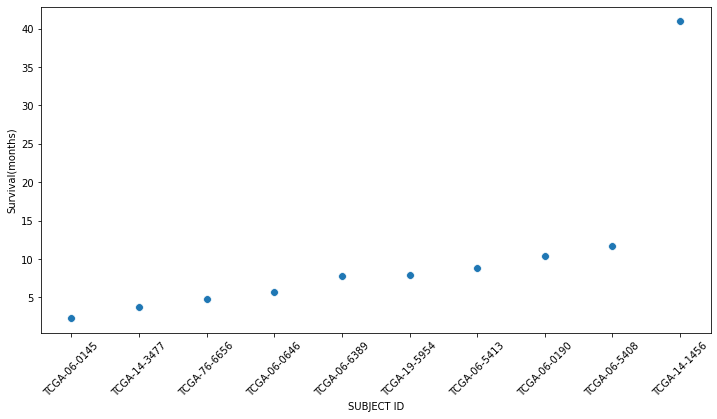

In [37]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='SUBJECT ID', y='Survival(months)', 
                     data=df.sort_values(by='Survival(months)'), s=60)
plt.xticks(rotation=45)
plt.show()

Here's the total tumor volume versus length of survival:

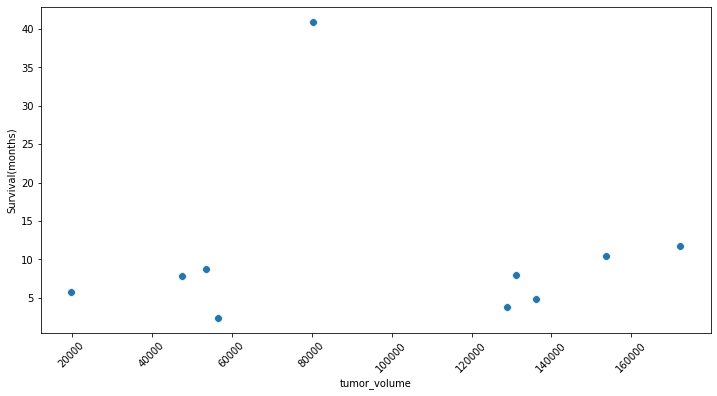

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='tumor_volume', y='Survival(months)', 
                     data=df.sort_values(by='Survival(months)'), s=60)
plt.xticks(rotation=45)
plt.show()

We can bin the survival data into two: <= 5 months, > 5 months, and then study how this relates to the various radiomics features:

In [39]:
df['short_survival'] = (df['Survival(months)'] <= 5).astype(str)

In [40]:
df

,SUBJECT ID,Age,Gender,Histology,Grade,IDH-status,IDH-allele,1p/19q-co-deletion,Survival(months),Karnofsky-score,img_dir,Volume_label1,Volume_label2,Max3DDiameter_label1,Max3DDiameter_label2,flair_MeanIntensity_label1,flair_MeanIntensity_label2,flair_IntensityVariance_label1,flair_IntensityVariance_label2,flair_GrayLevelNonUniformity_label1,flair_GrayLevelNonUniformity_label2,t1_MeanIntensity_label1,t1_MeanIntensity_label2,t1_IntensityVariance_label1,t1_IntensityVariance_label2,t1_GrayLevelNonUniformity_label1,t1_GrayLevelNonUniformity_label2,t1Gd_MeanIntensity_label1,t1Gd_MeanIntensity_label2,t1Gd_IntensityVariance_label1,t1Gd_IntensityVariance_label2,t1Gd_GrayLevelNonUniformity_label1,t1Gd_GrayLevelNonUniformity_label2,t2_MeanIntensity_label1,t2_MeanIntensity_label2,t2_IntensityVariance_label1,t2_IntensityVariance_label2,t2_GrayLevelNonUniformity_label1,t2_GrayLevelNonUniformity_label2,tumor_volume,short_survival
0,TCGA-06-0145,53.0,female,glioblastoma,G4,WT,NaN,non-codel,2.3327,NaN,TCGA-06-0145,30701.666666666668,26001.333333333332,72.69112738154499,56.60388679233962,545.8921598093483,520.2659944716356,17906.52913629047,38098.035974081926,44.54177215189873,35.222493142334656,272.2881671222263,300.8911941405508,760.963814509348,2055.9279469481894,218.96708860759495,124.33434928375495,263.96195090861215,403.4730680715558,1252.2859371457898,6356.05685158767,195.89822784810127,68.0149344711978,369.1607148119912,374.6749633934668,4666.609879669028,8987.498390312292,81.16911392405063,61.59006400487656,56703.0,True
1,TCGA-06-0190,62.0,male,glioblastoma,G4,WT,NaN,non-codel,10.4150,80.0,TCGA-06-0190,128178.66666666667,25481.333333333332,103.42146779078317,54.99090833947008,448.47799891863787,414.05654600791354,8183.998034473703,5077.549554372548,306.95888290296614,64.88644918444166,219.34303009950298,231.09337814898936,525.2833718668651,313.05529043499405,987.6021425475261,264.5583437892095,202.11789737420634,446.1568283538355,942.4245096865451,11401.596254106298,809.469874295622,41.909033877038894,315.6983059743882,345.50360072575234,3926.5152210325878,3926.4799072176406,370.7832683138275,79.02948557089084,153660.0,False
2,TCGA-06-0646,60.0,male,glioblastoma,G4,WT,NaN,non-codel,5.7496,80.0,TCGA-06-0646,15071.0,4880.333333333333,65.05382386916237,44.090815370097204,368.23676553751045,315.7693354455521,1062.9440616966094,2117.9095889277314,92.98032107716209,32.98073836276083,217.28098030878843,163.59997994271262,2668.4715551862255,761.8727425979386,53.53754531330917,41.080256821829856,200.47460352098344,563.0710983494077,4860.439596547637,20406.86922785635,44.81874676333506,8.081861958266453,290.6262460329831,306.0439045489912,2745.869626848196,1011.1389320704045,53.23925427239772,42.81701444622793,19951.333333,False
3,TCGA-06-5408,54.0,female,glioblastoma,G4,WT,NaN,non-codel,11.7292,80.0,TCGA-06-5408,121208.0,50953.0,99.31767214348109,83.09031231136396,429.72426684052107,377.2527808311832,7213.604300696047,7954.841262169011,252.65366492146597,101.60539523212046,241.71891632283172,256.99656876927025,732.9332289639475,690.7978677095699,833.9933246073299,375.7681932245922,228.82676088461366,404.0059628094657,1056.9074064245015,6694.625162770309,702.0369109947644,109.29015056461732,322.2113838593451,347.74623680549706,3648.171999648121,3265.09845728651,367.36832460732984,158.96957340025094,172161.0,False
4,TCGA-06-5413,67.0,male,glioblastoma,G4,WT,NaN,non-codel,8.8051,60.0,TCGA-06-5413,33458.666666666664,20032.666666666668,77.43384273042376,48.579831205964474,328.58563623859953,257.4923757296716,844.7533902348517,1505.888916048035,215.12354312354313,101.25448743518149,190.80601735480616,177.51050037401896,1941.8290595868957,1684.2995029226668,138.202331002331,90.71280414838452,171.68015038779063,351.8616641986365,2121.751960558949,11083.817264329013,134.2983682983683,37.81212604706821,263.80954202928586,241.5918065739007,1824.6695527099093,1936.2697336204399,138.97342657342656,89.79776625448744,53491.333333,False
5,TCGA-06-6389,49.0,fem

Here's a plot investigating the relation between the IDH status, survival times and volume of the enhancing-non-enhancing tumor regions:

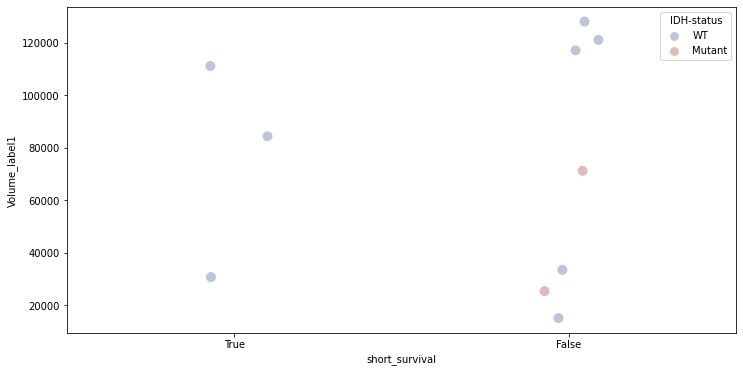

In [41]:
plt.figure(figsize=(12,6))
sns.stripplot(data=df, x="short_survival", y="Volume_label1", hue='IDH-status',palette="vlag", s=10)
plt.show()

# What's next?

Our sample data set is very small so we cannot say much at this point, but if you rerun this experiment using all the data available in TCGA-GBM you will have a data set that is quite large, comparably speaking. All the data is available through the TCGA database (after a simple access application process). You're therefore very close to being able to do some exciting research into brain tumors! 